In [ ]:
# These packages are not included in the MomentumED package. 
# Use the following line to add them:
# using Pkg; Pkg.add("CairoMakie"); Pkg.add("QuadGK"); Pkg.add("ClassicalOrthogonalPolynomials")

# Import the momentum-conserved exact diagonalization package
using MomentumED, LinearAlgebra
include("../Landau level torus.jl")
using .LLT

# square/triangular lattice
sqa_lattice = ReciprocalLattice(:square);          # == ReciprocalLattice(1, 0)
tri_lattice = ReciprocalLattice(:triangular);      # == ReciprocalLattice(1, -1//2)
# general_lattice = ReciprocalLattice(abs(G2/G1), cos(θ)), use exact value to avoid uncertainty on Brillouin Zone boundary.

using CairoMakie # for plotting
CairoMakie.activate!()

# Plot the energy spectrum
function plot_ed_spectrum(energies, vectors; title=nothing, ylims = (nothing, nothing))
    fig = Figure();
    ax = Axis(fig[1, 1];
        xlabel = "$(Gk[2])k1+k2",
        ylabel = "Energy per unit cell (W₀ = e²/ϵl)"
    )
    ax_top = Axis(fig[1, 1];
        xaxisposition = :top
    )
    top_ticks = ([], [])
    hidespines!(ax_top)
    hidexdecorations!(ax_top; label = false, ticklabels = false)
    hideydecorations!(ax_top)
    linkxaxes!(ax, ax_top)

    # Plot energy levels for each momentum block
    for i in 1:length(ss_k1)
        x = Gk[2] * ss_k1[i] + ss_k2[i]
        push!(top_ticks[1], x)
        push!(top_ticks[2], string(i))
        if isassigned(energies,i)
            for e in energies[i]
                scatter!(ax, x, e/Nk/LLT.W0, color = :blue, marker=:hline)
            end
        end
    end
    ylims!(ax, ylims...)
    ax_top.xticks = top_ticks
    if title isa String
        ax_top.subtitle = title
    end
    display(fig)
end

function plot_entanglement_spectrum(;title=nothing, ylims = (nothing, nothing))
    fig = Figure();
    ax = Axis(fig[1,1];
        xlabel = "Ne in A-part",
        xticksvisible = false,
        xgridvisible = false,
        xminorgridvisible = true,
    )

    x = 0
    NA_lines = Float64[-0.5;]
    xtickposition = Float64[];
    xticklabel = String[];
    for indexNA in CartesianIndices(entanglement_spectrum)
        x_begin = x
        for (indexkA, spectrum) in enumerate(entanglement_spectrum[indexNA])
            if !isempty(spectrum)
                for e in spectrum
                    scatter!(ax, x, e, color = :blue, marker=:hline)
                end
                x += 1
            end
        end
        x_end = x
        if x_end > x_begin
            NA = string(indexNA[1]-1)
            for i in 2:length(indexNA)
                NA *= ",$(indexNA[i]-1)"
            end
            push!(xtickposition, 0.5(x_begin+x_end-1))
            push!(xticklabel, NA)
            push!(NA_lines, x+0.5)
        end
    end
    ax.xticks = (xtickposition, xticklabel)
    ax.xminorticks = NA_lines
    if title isa String
        ax.subtitle = title
    end
    ylims!(ax, ylims...)
    display(fig)
end

plot_entanglement_spectrum (generic function with 1 method)

In [ ]:
# Define 3×4 k-mesh (Nk=13) for 1/3 + 1/3 filling
k_list = [0 1 2 0 1 2 0 1 2 0 1 2;
          0 0 0 1 1 1 2 2 2 3 3 3]

# System parameters
Nk = 12         # Total number of k-points
Gk = (3, 4)     # Grid dimensions (G1_direction, G2_direction)

# Number of layers (components) for bilayer system
Nc_conserve = 2

2

In [97]:
# Define 3×5 k-mesh (Nk=15) for 1/3 + 1/3 filling
k_list = [0 1 2 0 1 2 0 1 2 0 1 2 0 1 2;
          0 0 0 1 1 1 2 2 2 3 3 3 4 4 4]

# System parameters
Nk = 15         # Total number of k-points
Gk = (3, 5)     # Grid dimensions (G1_direction, G2_direction)

# Number of layers (components) for bilayer system
Nc_conserve = 2

2

In [98]:
# Set up one-body Hamiltonian matrix for inter-layer tunneling
ΔE = 0.0 * LLT.W0                # Energy difference between the two layers

# H_onebody[c1, c2, cc, k] : no hopping from component c2 to c1
# For bilayer system: Nc_hopping=1, Nc_conserve=2, No tunneling
H_onebody_bilayer_no_tunneling = zeros(ComplexF64, 1, 1, Nc_conserve, Nk)
for k_idx in 1:Nk
    H_onebody_bilayer_no_tunneling[1, 1, 1, k_idx] = 0.5ΔE
    H_onebody_bilayer_no_tunneling[1, 1, 2, k_idx] = -0.5ΔE
end

# Set up component parameters: (layer, level, Chern number, pseudospin)
sys_int = LandauInteraction(tri_lattice,
    (1, 0, 1, 0),
    (2, 0, 1, 0)
);

In [99]:
# Interaction parameters

# Coulomb
sys_int.D_l = 10.0                  # Screening length D/l
sys_int.d_l = 0.5                  # Inter-layer distance d/l
# compute the pseudo-potential components
# intra_PP = LLT.pseudo_potential_decomposition.(0:4; same_layer = true,  D_l = sys_int.D_l, d_l = sys_int.d_l)
# inter_PP = LLT.pseudo_potential_decomposition.(0:4; same_layer = false, D_l = sys_int.D_l, d_l = sys_int.d_l)
@show intra_PP
@show inter_PP

# Haldane pseudo-potential
# sys_int.V_intra = [0.0; 0.8; 0.0; 0.4]          # Intralayer Haldane pseudo-potential in unit of W0
# sys_int.V_inter = [1.0; 0.7; 0.5; 0.4]          # Interlayer Haldane pseudo-potential in unit of W0

# or use Coulomb interaction with a cutoff in m
sys_int.V_intra = copy(intra_PP)
sys_int.V_inter = copy(inter_PP)

# choose a linear mixing between Haldane and Coulomb interaction
sys_int.mix = 0                  # mix * Haldane + (1-mix) * Coulomb

# Create parameter structure for bilayer system
para = EDPara(
    k_list = k_list, 
    Gk = Gk, 
    Nc_hopping = 1,
    Nc_conserve = Nc_conserve,
    H_onebody = H_onebody_bilayer_no_tunneling,
    V_int = sys_int,
    FF_inf_angle = LLT.Landau_ff_inf(sys_int),
);

intra_PP = [1.6211521871756613, 0.7362064137807713, 0.5159010387971854, 0.4063453807964281, 0.33830404695298427]
inter_PP = [0.2377938474477338, 0.216554176424282, 0.19858061379194739, 0.18317219039416288, 0.1698135904604977]


In [100]:
# number of electrons in each layer
Ne1 = 5
Ne2 = 5

5

In [101]:
NG = 2
index_shift = NG .* Gk .+ 1
densities = MBOperator[density_operator(q1, q2, lf, li; 
        para = para, form_factor = true)
    for q1 in -NG*Gk[1]:NG*Gk[1], q2 in -NG*Gk[2]:NG*Gk[2], lf = 1:2, li=1:2
];
function structure_factor_expectation(myvec)
    structure_factor = similar(densities, ComplexF64)
    for q1 in -NG*Gk[1]:NG*Gk[1], q2 in -NG*Gk[2]:NG*Gk[2]
        for lf = 1:2, li = 1:2
            structure_factor[index_shift[1]+q1, index_shift[2]+q2, lf, li] = 
                ED_bracket_threaded(myvec, 
                    densities[index_shift[1]-q1, index_shift[2]-q2, li, lf], 
                    densities[index_shift[1]+q1, index_shift[2]+q2, lf, li], myvec
                )
            if mod(q1, Gk[1]) == 0 && mod(q2, Gk[2])== 0 && lf==li
                structure_factor[index_shift[1]+q1, index_shift[2]+q2, lf, li] -= 
                    ED_bracket_threaded(myvec, densities[index_shift[1]-q1, index_shift[2]-q2, li, lf], myvec) * 
                    ED_bracket_threaded(myvec, densities[index_shift[1]+q1, index_shift[2]+q2, lf, li], myvec)
            end
        end
    end
    structure_factor ./= Nk
end

structure_factor_expectation (generic function with 1 method)

In [102]:
# Create momentum blocks (Hilbert subspace) for bilayer system
subspaces, ss_k1, ss_k2 = 
    ED_momentum_subspaces(para, (Ne1, Ne2));
display(length.(subspaces))

# Generate Scatter lists for efficient Hamiltonian construction
scat_list1 = ED_sortedScatterList_onebody(para);
scat_list2 = ED_sortedScatterList_twobody(para);

# construct the Hamiltonian operator
hmlt = MBOperator(scat_list2, scat_list1; upper_hermitian = true)

15-element Vector{Int64}:
 601203
 601200
 601200
 601200
 601200
 601203
 601200
 601200
 601200
 601200
 601203
 601200
 601200
 601200
 601200

Many Body Operator (upper_hermitian=true) :
	Vector{MomentumEDCore.Scatter{2}} with 2640 scattering terms


In [ ]:
Neigen = 10  # Number of eigenvalues to compute per subspace
energies55 = Vector{Vector{Float64}}(undef, length(subspaces));
vectors55 = Vector{Vector{<:MBS64Vector}}(undef, length(subspaces));
for i in eachindex(subspaces)
    println("Processing subspace #$i with size $(length(subspaces[i])), momentum $(ss_k1[i]), $(ss_k2[i])")
    energies55[i], vectors55[i] = EDsolve(subspaces[i], scat_list2, scat_list1;
        N=Neigen, showtime=true, ishermitian=true
    )
end

Processing subspace #1 with size 601203, momentum 0, 0
 11.698733 seconds (910.89 k allocations: 20.697 GiB, 12.61% gc time, 6.27% compilation time)


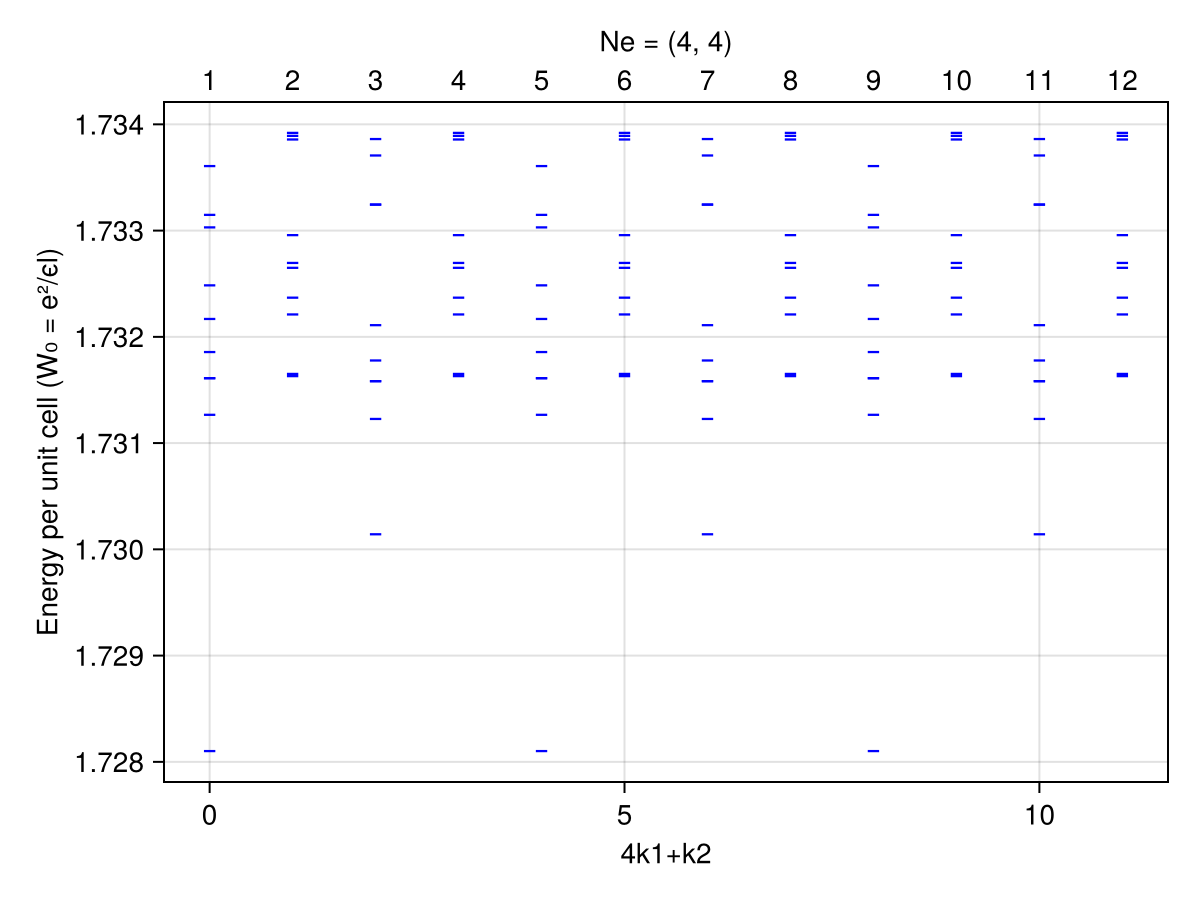

In [89]:
plot_ed_spectrum(title="Ne = ($Ne1, $Ne2)");

In [90]:
# check energies explicitly to see degeneracy.

sn = 1 # the subspace number to inspect
println("total momentum: ", ss_k1[sn], "  ", ss_k2[sn])
energies[sn]/Nk/LLT.W0

total momentum: 0  0


10-element Vector{Float64}:
 1.7281011979564254
 1.7312659691182946
 1.7316105719534185
 1.731610571953424
 1.7318567877388453
 1.7321680789655443
 1.7324844368349728
 1.7330299412758157
 1.7331478751262832
 1.7336070799916536

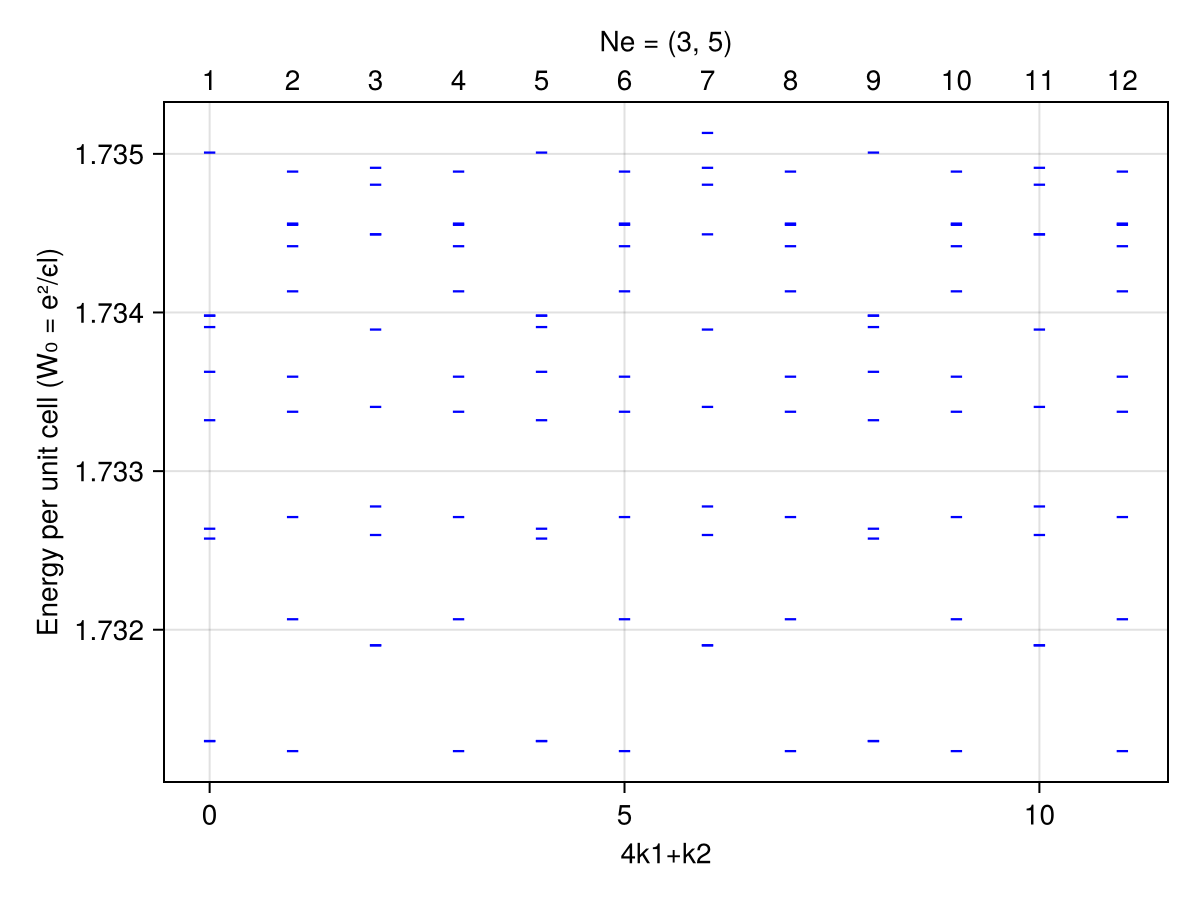

In [83]:
plot_ed_spectrum(title="Ne = ($Ne1, $Ne2)");

In [ ]:
# check energies explicitly to see degeneracy.

sn = 1 # the subspace number to inspect
println("total momentum: ", ss_k1[sn], "  ", ss_k2[sn])
energies[sn]/Nk/LLT.W0

total momentum: 0  0


10-element Vector{Float64}:
 1.7312983363592165
 1.7312983363592191
 1.732574715134654
 1.7326369574373828
 1.733321082991382
 1.7336261179589565
 1.7339082983860894
 1.7339800950229591
 1.733980095022966
 1.7350080751588084

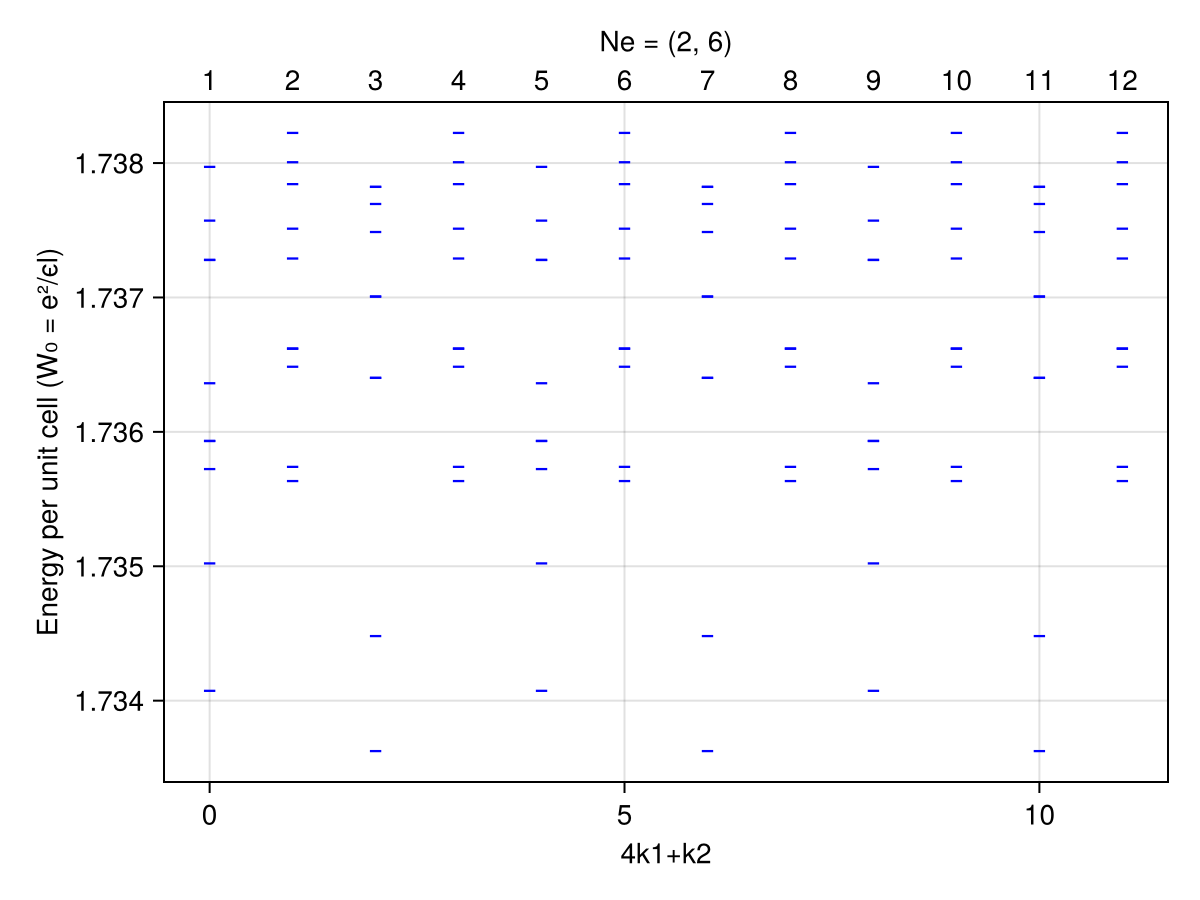

total momentum: 0  0


10-element Vector{Float64}:
 1.734073316337269
 1.7350213834856698
 1.7357232010391332
 1.735932519325175
 1.7359325193251773
 1.7363618326204486
 1.73727946552817
 1.7372794655281754
 1.7375719873574795
 1.737971849488271

In [96]:
plot_ed_spectrum(title="Ne = ($Ne1, $Ne2)");
sn = 1 # the subspace number to inspect
println("total momentum: ", ss_k1[sn], "  ", ss_k2[sn])
energies[sn]/Nk/LLT.W0

In [43]:
@time str_fac = structure_factor_expectation(vectors[1][1]);
@show maximum(abs.(imag.(str_fac)))
@show extrema(real.(str_fac))
@show str_fac[index_shift..., 1,2]
@show str_fac[index_shift..., 2,1]

278.887475 seconds (96.72 k allocations: 6.330 MiB, 0.01% compilation time)
maximum(abs.(imag.(str_fac))) = 3.23815048849004e-18
extrema(real.(str_fac)) = (-6.158037043254201e-14, 1.985883036083703)
str_fac[index_shift..., 1, 2] = 1.9858830360837028 + 1.314768175368353e-32im
str_fac[index_shift..., 2, 1] = 1.985883036083703 - 1.314768175368353e-32im


1.985883036083703 - 1.314768175368353e-32im

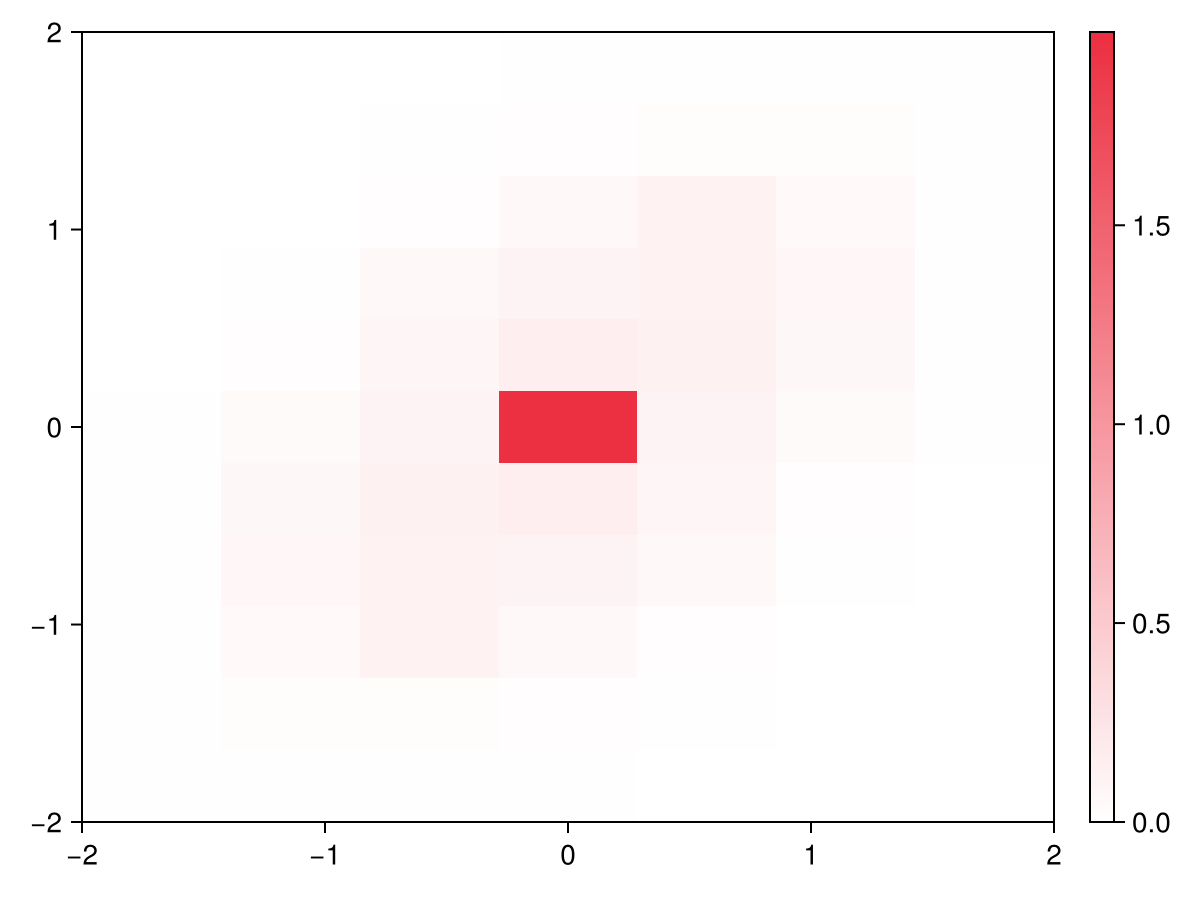

CairoMakie.Screen{IMAGE}


In [42]:
let structure_factor = str_fac, layer = (2,1)
    fig = Figure();
    ax = Axis(fig[1,1])
    hm = heatmap!(ax, (-2Gk[1]:2Gk[1])./Gk[1], (-2Gk[2]:2Gk[2])./Gk[2], 
        real.(structure_factor[:,:,layer...]);
        colorrange = (0.0, maximum(real.(structure_factor[:,:,layer...]))),
        colormap = range(Makie.Colors.colorant"white", stop=Makie.Colors.colorant"#ec2f41", length=15)
    )
    Colorbar(fig[1, 2], hm)
    display(fig)
end

Calculate many-body Chern number

In [20]:
# twist angle path for the Wilson loop integral
N_shift = 10  # number of shifts along each edge
path = Tuple{Float64, Float64}[(0.0, 0.0)]
push!(path, (1/N_shift, 0.0))
push!(path, (1/N_shift, 1/N_shift))
push!(path, (0.0, 1/N_shift))
push!(path, (0.0, 0.0))
path

5-element Vector{Tuple{Float64, Float64}}:
 (0.0, 0.0)
 (0.1, 0.0)
 (0.1, 0.1)
 (0.0, 0.1)
 (0.0, 0.0)

In [36]:
sn = 1                     # subspace number
nstates = 1                # number of degenerating states

psi_before = vectors[sn][1:nstates]
ED_connection_gaugefixing!(psi_before)  # fix global phase

WilsonLoopIntegral= Vector{Float64}(undef, 4)
for i in eachindex(WilsonLoopIntegral)

    println("path point #$i \t $(path[i+1])")

    if path[i+1] == (0.0, 0.0)
        psi_after = vectors[sn][1:nstates]
        ED_connection_gaugefixing!(psi_before)  # fix global phase
    end

    # One-body terms do not change when k are shifted
    scat2 = ED_sortedScatterList_twobody(para; kshift = path[i+1]);
    psi_after = EDsolve(subspaces[sn], scat2, scat_list1; N = 6,
        showtime = false,
    )[2][1:nstates]
    ED_connection_gaugefixing!(psi_after)  # fix global phase

    WilsonLoopIntegral[i] = ED_connection_step( 
        psi_after, psi_before, path[i+1], path[i], para;
        wavefunction_tol = 1e-8, print_amp = true,
        amp_warn_tol = 0.7, amp_warn = true
    )

    psi_before .= psi_after
end
ManyBodyChernNumber = sum(WilsonLoopIntegral) / (2π) * N_shift^2


path point #1 	 (0.1, 0.0)
Inner product: amp = 0.9999999999999719, phase = -0.10471975511984832
path point #2 	 (0.1, 0.1)
Inner product: amp = 0.9999999999999714, phase = 0.20943951023855437
path point #3 	 (0.0, 0.1)
Inner product: amp = 1.0000000000000306, phase = 0.12566370614545003
path point #4 	 (0.0, 0.0)
Inner product: amp = 1.0000000000000382, phase = -0.18849555921516398


0.6666666666846223